In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models import SeResNeXt
from torchvision import transforms
from torchvision.datasets import EuroSAT
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/senet")
data_path = Path("../../data/euroSAT")

In [4]:
device = torch.device("cuda:0")

# data

In [6]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [7]:
dataset = EuroSAT(
    data_path.as_posix(),
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

In [9]:
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [10]:
len(dataset)

27000

Highway


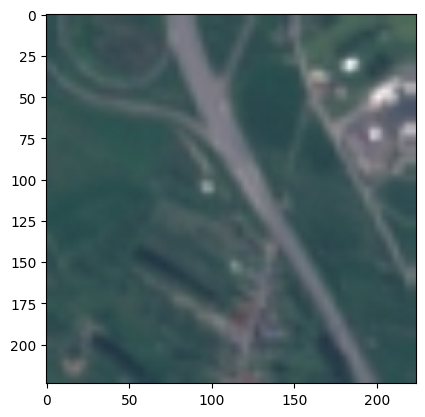

In [11]:
import random
demo_img, demo_label = dataset[random.randint(0, len(dataset))]
print(dataset.classes[demo_label])
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [17]:
model = SeResNeXt(output_size=num_class, num_layer=50).to(device)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
SeResNeXt                                          --
├─Sequential: 1-1                                  --
│    └─ConvBnRelu: 2-1                             --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    └─MaxPool2d: 2-2                              --
├─Sequential: 1-2                                  --
│    └─ResBlock: 2-3                               --
│    │    └─SeXBottleNeck: 3-4                     55,056
│    │    └─ConvBnRelu: 3-5                        16,896
│    └─ResBlock: 2-4                               --
│    │    └─SeXBottleNeck: 3-6                     79,632
│    │    └─Identity: 3-7                          --
│    └─ResBlock: 2-5                               --
│    │    └─SeXBottleNeck: 3-8                     79,632
│    │    └─Identity: 3-9                          --
├─S

# training

In [14]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [15]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [16]:
training_loss = []

model.train()
for e in range(epoches):
    running_loss = 0.0
    acc_iter = 0
    optim.zero_grad()
    
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        
        output = model(img)
        loss = criterion(output,label)
        loss /= acc_iters
        loss.backward()

        if acc_iter % acc_iters == 0:
            optim.step()
            optim.zero_grad()
            
        running_loss += loss.item()
        acc_iter += 1

    training_loss.append(running_loss/len(dataset))
    
    print(f'epoch {e+1}: {training_loss[e]}')

100%|██████████| 1687/1687 [14:56<00:00,  1.88it/s]


epoch 1: 0.012598392383678369


100%|██████████| 1687/1687 [05:58<00:00,  4.71it/s]


epoch 2: 0.006193046011289375


100%|██████████| 1687/1687 [05:55<00:00,  4.74it/s]


epoch 3: 0.004395779596848621


100%|██████████| 1687/1687 [06:02<00:00,  4.65it/s]


epoch 4: 0.0035660976588260383


100%|██████████| 1687/1687 [05:51<00:00,  4.79it/s]


epoch 5: 0.0032317346222526223


100%|██████████| 1687/1687 [05:57<00:00,  4.72it/s]


epoch 6: 0.002800589269533736


100%|██████████| 1687/1687 [05:57<00:00,  4.71it/s]


epoch 7: 0.002580067673429666


100%|██████████| 1687/1687 [05:56<00:00,  4.73it/s]


epoch 8: 0.0023300056251971033


100%|██████████| 1687/1687 [05:58<00:00,  4.71it/s]


epoch 9: 0.0022301455373030707


100%|██████████| 1687/1687 [06:07<00:00,  4.60it/s]

epoch 10: 0.0019799260208480216


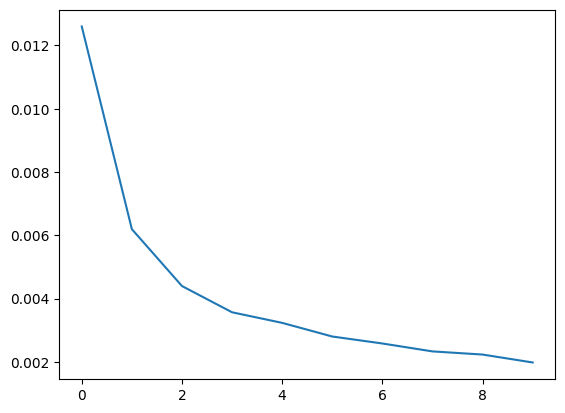

In [17]:
plt.plot(training_loss)

# inference

In [9]:
test_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [10]:
test_dataset = EuroSAT(
    data_path.as_posix(),
    transform=test_preprocess,
    download=True,
)

In [11]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [12]:
evaluator = ClassificationEvaluator(num_class, device)

In [27]:
confusion_matrix = IncrementalConfusionMatrix(num_class)

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        
        output = model(img)
        output = output.detach().cpu()

        output = output.argmax(dim=1)
        confusion_matrix.update(label, output)

100%|██████████| 1688/1688 [02:28<00:00, 11.34it/s]


In [28]:
print(confusion_matrix)

[[2859    1   15    4    0   11   73    0    6   31]
 [   0 2986    1    0    0    2    1    0    1    9]
 [   1   13 2771    2    3    8  197    2    0    3]
 [   3    1    1 2455   18    3    8    1   10    0]
 [   0    0    0    3 2492    0    3    2    0    0]
 [  20   19   40    0    0 1885    4    0    9   23]
 [  17    2   10    2    5   14 2450    0    0    0]
 [   0    0    0    1   18    0    1 2980    0    0]
 [  22    2    4   14    6    2   12    0 2432    6]
 [   0    0    0    0    0    0    0    0    4 2996]]


In [29]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

AnnualCrop: 0.953
Forest    : 0.9953333333333333
HerbaceousVegetation: 0.9236666666666666
Highway   : 0.982
Industrial: 0.9968
Pasture   : 0.9425
PermanentCrop: 0.98
Residential: 0.9933333333333333
River     : 0.9728
SeaLake   : 0.9986666666666667


In [30]:
per_class_acc.mean()

0.97381

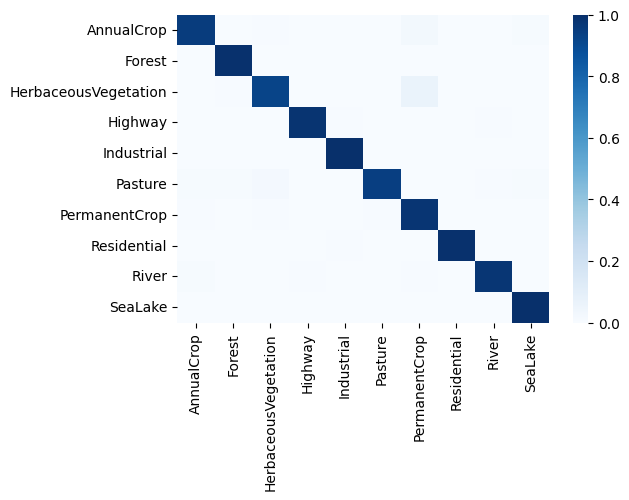

In [31]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [14]:
model_path = artifact_path / 'se-resnext50.pth'

In [19]:
torch.save(model.state_dict(), model_path)

In [15]:
get_file_size(model_path)

'97.79MB'

In [18]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>